In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [ ]:
!pip install kaggle

!kaggle datasets download -d sshikamaru/udacity-self-driving-car-dataset


In [ ]:
dataset_path = '/Users/Pauline/autonomous-vehicle-classifier/udacity-self-driving-car-dataset/data/export'
annotatinos_path = '/Users/Pauline/autonomous-vehicle-classifier/udacity-self-driving-car-dataset/data/export/_annotations.csv'

In [ ]:
annotations_path = os.path.join(dataset_path, '_annotations.csv')
annotations = pd.read_csv(annotations_path)
img_path = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('jpg')]

annotations.head()


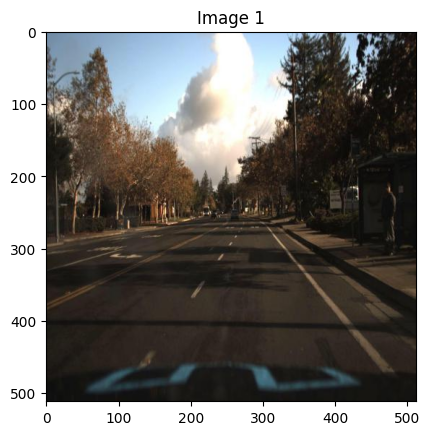

<bound method NDFrame.head of                                                  filename  width  height  \
0       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
...                                                   ...    ...     ...   
194534  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194535  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194536  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194537  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194538  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   

             class  xmin  ymin  xmax  ymax  
0           

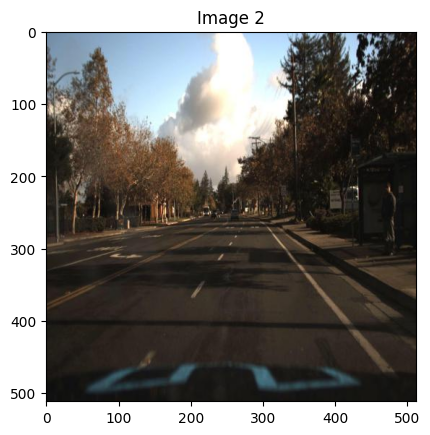

<bound method NDFrame.head of                                                  filename  width  height  \
0       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
...                                                   ...    ...     ...   
194534  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194535  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194536  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194537  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194538  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   

             class  xmin  ymin  xmax  ymax  
0           

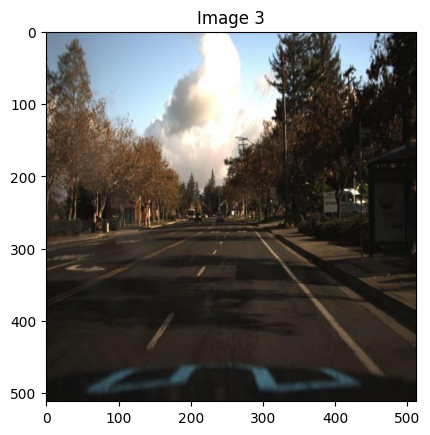

<bound method NDFrame.head of                                                  filename  width  height  \
0       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
...                                                   ...    ...     ...   
194534  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194535  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194536  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194537  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194538  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   

             class  xmin  ymin  xmax  ymax  
0           

In [52]:
for i in range (3):
    img = Image.open(img_path[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.show()
    print(annotations.head)

In [ ]:
def iou(boxA, boxB):
    xA = max([boxA[0], boxB[0]])
    yA = max([boxA[1], boxB[1]])
    xB = min([boxA[2], boxB[2]])
    yB = min([boxA[3], boxB[3]])
    
    interArea = max(0, xB - xA+1) * max(0, yB - yA+1)
    
    #boxA = ground truth boxB = predicted
    boxAArea = (boxA[2] - boxA[0]+1) * (boxA[3] - boxA[1]+1)
    boxBArea = (boxB[2] - boxB[0]+1) * (boxB[3] - boxB[1]+1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

#remove 100% duplicate bounding boxes based on IoU threshold
def filter_duplicates(boxes, threshold=1):
    filtered_boxes = []
    for i, boxA in enumerate(boxes):
        to_add = True
        for boxB in filtered_boxes:
            if iou(boxA, boxB) == threshold:
                to_add = False
                break
        if to_add:
            filtered_boxes.append(boxA)
    return filtered_boxes

#example
bounding_boxes = [
    [100, 150, 200, 250],
    [100, 150, 200, 250],
    [110, 160, 210, 260],
]

filtered_boxes = filter_duplicates(bounding_boxes)
print(filtered_boxes)
iou_value = iou(bounding_boxes[0], bounding_boxes[1])
print(f"IoU between boxA and boxB: {iou_value}")

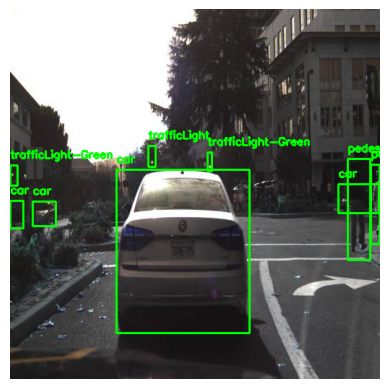

In [50]:
grouped_annotations = annotations.groupby("filename")

def draw_bounding_boxes(image_file, boxes, save_image=False, output_path=None):
    img_path = os.path.join(dataset_path, image_file)
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {img_path}")

    #draw each bounding box
    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        label = row['class']

        #draw rectangle
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # Put label text
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if save_image:
        # Save image with bounding boxes
        if output_path:
            cv2.imwrite(output_path, image)  #save to given output path
        else:
            cv2.imwrite('output.jpg', image)  #default save

    #convert BGR to RGB for displaying
   # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

image_file = "1478899844799782363_jpg.rf.RAjpKgjL9L1sH6Yztakh.jpg"
boxes = grouped_annotations.get_group(image_file)  # Retrieve bounding boxes for the image
draw_bounding_boxes(image_file, boxes)


In [ ]:
def normalize_bounding_boxes(bboxes, image_width, image_height):
    normalized_bboxes = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        
        #normalize bounding box coordinates
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        normalized_bboxes.append([x_center, y_center, width, height])
    
    return normalized_bboxes

image_width = 512
image_height = 512
bounding_boxes = [
    [100, 150, 200, 250],  #xmin, ymin, xmax, ymax
    [110, 160, 210, 260]
]

filtered_boxes = filter_duplicates(bounding_boxes)

#normalize bounding boxes
image_width = 512
image_height = 512
normalized_boxes = normalize_bounding_boxes(filtered_boxes, image_width, image_height)